In [ ]:
## Run in python 2.7+
# Script for all sensor data

import sys

import arable
from   arable.client     import ArableClient 
a = ArableClient()
from   sensor_includes   import email, password_ccber, tenant_ccber

a.connect(email = email, password = password_ccber, tenant = tenant_ccber)

import re
import matplotlib.pyplot as plt
import numpy             as np
import matplotlib.dates  as mdates
import altair            as alt

# Enable altair usage in Jupyter Notebook
alt.renderers.enable('notebook')

from   datetime          import timedelta
from   datetime          import datetime

dt = datetime.now()

import pandas            as     pd
from   pandas.plotting   import register_matplotlib_converters

register_matplotlib_converters()

from   io                import StringIO

import arable_data_dict  as dd

In [ ]:
# Datetime object to string with format "%Y-%m-%dT%H:%M:%SZ"
def dt_to_ymd_hms(x):
    return x.strftime("%Y-%m-%dT%H:%M:%SZ")
# Append string with format "%Y-%m-%dT%H:%M:%SZ" to list
def append_ymd_hms(a, b):
    a.append(dt_to_ymd_hms(b))
# Reverses dt_to_ymd_hms
def ymd_hms_to_dt(x):
    return datetime.strptime(x, "%Y-%m-%dT%H:%M:%S")

# Datetime object to string with format "%Y-%m-%d"
def dt_to_ymd(x):
    return x.strftime("%Y-%m-%d")
# Reverse dt_to_ymd
def ymd_to_dt(x):
    return datetime.strptime(x, "%Y-%m-%d")

# Datetime object to string with format "%Y-%m"
def dt_to_ym(x):
    return x.strftime("%Y-%m")
# Append string with format "%Y-%m" to list
def append_ym(a, b):
    try:
        a.append(dt_to_ym(b))
    except:
        a.append(dt_to_ym(ym_to_dt(b)))
# Reverse dt_to_ym
def ym_to_dt(x):
    return datetime.strptime(x, "%Y-%m")

# Append string to list
def append_string(a, b):
    a.append(str(b))
    
# Append temporary lists to list
def append_temp_list(temp_list, main_list):
    main_list.append(temp_list)

In [12]:
## Run in python 2.7
# Script for all sensor data

import sys

import arable
from   arable.client     import ArableClient 
a = ArableClient()
from   sensor_includes   import email, password_ccber, tenant_ccber

a.connect(email = email, password = password_ccber, tenant = tenant_ccber)

import re
import matplotlib.pyplot as plt
import numpy             as np
import matplotlib.dates  as mdates
import altair            as alt

# Enable altair usage in Jupyter Notebook
alt.renderers.enable('notebook')

from   datetime          import timedelta
from   datetime          import datetime

dt = datetime.now()

import pandas            as     pd
from   pandas.plotting   import register_matplotlib_converters

register_matplotlib_converters()

from   io                import StringIO

import arable_data_dict  as dd

# Datetime object to string with format "%Y-%m-%dT%H:%M:%SZ"
def dt_to_ymd_hms(x):
    return x.strftime("%Y-%m-%dT%H:%M:%SZ")
# Append string with format "%Y-%m-%dT%H:%M:%SZ" to list
def append_ymd_hms(a, b):
    a.append(dt_to_ymd_hms(b))
# Reverses dt_to_ymd_hms
def ymd_hms_to_dt(x):
    return datetime.strptime(x, "%Y-%m-%dT%H:%M:%S")

# Datetime object to string with format "%Y-%m-%d"
def dt_to_ymd(x):
    return x.strftime("%Y-%m-%d")
# Reverse dt_to_ymd
def ymd_to_dt(x):
    return datetime.strptime(x, "%Y-%m-%d")

# Datetime object to string with format "%Y-%m"
def dt_to_ym(x):
    return x.strftime("%Y-%m")
# Append string with format "%Y-%m" to list
def append_ym(a, b):
    try:
        a.append(dt_to_ym(b))
    except:
        a.append(dt_to_ym(ym_to_dt(b)))
# Reverse dt_to_ym
def ym_to_dt(x):
    return datetime.strptime(x, "%Y-%m")

# Append string to list
def append_string(a, b):
    a.append(str(b))
    
# Append temporary lists to list
def append_temp_list(temp_list, main_list):
    main_list.append(temp_list)

def arable_query(s, b, c, d, e, f, g):
    dev = "['" + str(c) + "']"
    df = a.query( select = str(s),
                  format = str(b),
                 devices = dev,
                 measure = str(d),
                   order = str(e),
                     end = f,
                   start = g,
                   limit = 5000) #100000000)
    df = StringIO(df)
    df = pd.read_csv(df, sep=',', error_bad_lines=False)
    return df


# sensors = [str(i['name']) for i in a.devices]
# Try this instead of the for loop?
sensors = []
for i in a.devices():
    sensors.append(str(i['name']))

print(sensors)

known_sensors        = ['A000522', 'A000536', 'A000502', 'A000563', 'A000507', 'A000229', 'A000513', 'A000465', 'A000318', 'A000369', 'A000466', 'A000546', 'A000514', 'A000417', 'A000461', 'A000543', 'A001512', 'A000502']
deprecated_sensors   = ['A000502', 'A000514', 'A000417', 'A000543', 'A001512', 'A000461']
known_active_sensors = list(set(known_sensors) - set(deprecated_sensors))
known_active_sensors = sorted(known_active_sensors, key=lambda x: int(re.search(r'\d+$',x).group()))

new_active_sensors = list(set(sensors) - set(known_sensors))

new_active_sensors = sorted(new_active_sensors, key=lambda x: int(re.search(r'\d+$',x).group()))


# FOUND NEW SENSOR WITH ID # A000*** ... ERROR - NO DATA AVAILABLE!!
# FOUND NEW SENSOR WITH ID # A000*** ... DATA RECEIVED ... ERROR - SENSOR NOT IN RANGE!!
# FOUND NEW SENSOR WITH ID # A000*** ... DATA RECEIVED ... SENSOR ENABLED!

if len(new_active_sensors) != 0:
    for i in new_active_sensors:
        print("FOUND NEW SENSOR: ", str(i),)
        for device in a.devices():
            if str(device['name']) == i:
                # Checks sensors are in the correct location (within a specific range of latitude/longitude coordinates).
                date_created   = ymd_hms_to_dt(str(i['created'])[:19])
                date_last_seen = ymd_hms_to_dt(str(i['last_seen'])[:19])
                try:
                    df = arable_query('all','csv',[device_id],"daily","time",dt,dt_to_ymd_hms(dt - timedelta(days = 1)))
                    latitude  = float(str(df['lat' ].values.astype(float)).strip('[ ]'))
                    longitude = float(str(df['long'].values.astype(float)).strip('[ ]'))
                    print("... DATA RECEIVED")
                    if 34.3 <= latitude <= 35.07 and -120.610 <= longitude <= -119.740:
                        print("... SENSOR ENABLED!")
                        known_active_sensors.append(i)
                    else:
                        print("... ERROR - SENSOR NOT IN RANGE!!")
                        # Potentially add something that notifies user of error?
                        
                except:
                    print('... ERROR - NO DATA AVAILABLE!!')
else:
    print("NO NEW SENSORS DETECTED.")
    
print("Retrieving new data from... ")
for i in range(len(known_active_sensors)//4 + 1):
    print('\t'.join(known_active_sensors[i*4:(i+1)*4]) + '\n')

device_id           = [] # Ex. A00****
device_location     = [] # Ex. Lagoon Ice Plants
device_date_created = [] # Ex. 2019-10-10T00:00:00
device_latitude     = []
device_longitude    = []
device_flags        = []
device_info         = []
# The devices of interest have Z in the Location Name on the Arable website.
# These Location Names are added to device_location.
# The corresponding Device ID is added to device_id.


for i in a.devices():
    for j in known_active_sensors:
        if i['name'] == j:
            device_location.append(str(i['location']['name']))
            device_id.append(str(i['name']))
            flags=[]
            for k in i['flags']:
                flags.append(str(k.strip('[ ]')))
            device_flags.append(flags)
            device_date_created.append(str(i['created'])[:19])
            #device_latitude.append(float(str(df['lat'].values).strip('[ ]')))
            #device_longitude.append(float(str(df['long'].values).strip('[ ]')))
            temp = {'ID'           : str(i['name']),
                    'Location'     : str(i['location']['name'])[1:],
                    'Date Created' : ymd_hms_to_dt(str(i['created'])[:19]),
                    'Flags'        : str(flags),
                    'n'            : len(device_info) + 1}
            device_info.append(temp)

# Converts each item in device_id to a list.          
device_id              = list(map(lambda el:[el], device_id))
device_date_created_dt = [ymd_hms_to_dt(i) for i in device_date_created]

print(['{:<7}'.format(str(i)) for i in device_id])

device_info = pd.DataFrame(device_info)
device_info.to_csv(str('Sensor-Info_' + str(dt_to_ymd(dt)) + '.txt'), sep = ",")
print(device_info)

['A000369', 'A000546', 'A000522', 'A000465', 'A000507', 'A000229', 'A000536', 'A000318', 'A000563', 'A000466', 'A000513', 'A000502', 'A001512', 'A000514', 'A000417', 'A000461', 'A000543']
NO NEW SENSORS DETECTED.
Retrieving new data from... 
A000229	A000318	A000369	A000465

A000466	A000507	A000513	A000522

A000536	A000546	A000563

["['A000369']", "['A000546']", "['A000522']", "['A000465']", "['A000507']", "['A000229']", "['A000536']", "['A000318']", "['A000563']", "['A000466']", "['A000513']"]
          Date Created                          Flags       ID  \
0  2019-03-12 23:12:28                ['Orientation']  A000369   
1  2019-03-12 23:08:06                ['Orientation']  A000546   
2  2019-03-20 19:32:35                ['Orientation']  A000522   
3  2019-02-05 21:44:10                ['Orientation']  A000465   
4  2019-03-18 18:45:32                ['Orientation']  A000507   
5  2019-02-05 23:19:19     ['Battery', 'Orientation']  A000229   
6  2019-02-06 00:43:30                [

In [10]:
device_created = pd.read_csv(str('Sensor-Info_' + str(dt_to_ymd(dt)) + '.txt'), sep = ",")['Date Created'].values.tolist() 
# Monthly
m_start    = []
m_start_fn = []
m_end      = []
m_end_fn   = []

# Yearly
y_start    = []
y_start_fn = []
y_end      = []
y_end_fn   = []

# All Time
astart     = []
start_fn   = []
end        = []
end_fn     = []

for j in range(len(device_created)):
    ms  = []
    msf = []
    me  = []
    mef = []
    
    ys  = []
    ysf = []
    ye  = []
    yef = []
    
    s   = []
    sf  = []
    e   = []
    ef  = []
    
    def new_month(new_m):
        append_ymd_hms(ms, new_m)
        append_string(me, new_m)
        append_ym(msf, new_m)  
        append_ym(mef, new_m)
        
    def new_year(new_y):
        append_ymd_hms(ys, new_y)
        append_string(ye, new_y)
        append_ym(ysf, new_y)
        append_ym(yef, new_y)
    
    device_created_ymd = (device_created[j])[:10]
    start              = ymd_to_dt(device_created_ymd)
    append_string(ms, start)
    append_string(ys, start)
    append_string(s, start)
    append_ym(msf, start)
    append_ym(ysf, start)
    append_ym(sf, start)
    
    start  = start.replace(day=1)
    
    if start.year == dt.year:
        for i in range(start.month+1, dt.month+1):
            new_month(start.replace(month=i))
    
    elif start.year != dt.year: 
        for i in range(dt.year-start.year):
            for j in range(start.month+1, 13): 
                new_month(start.replace(month=j))
        for i in range(start.year+1, dt.year+1):
            newyr = start.replace(year=i, month=1)
            new_year(newyr)
            for j in range(1, dt.month+1):
                new_month(newyr.replace(month=j))
    
    append_string(me, dt)
    append_string(ye, dt)
    append_string(e, dt)
    append_ym(mef, dt)
    append_ym(yef, dt)
    append_ym(ef, dt)
    
    append_temp_list(ms, m_start)
    append_temp_list(me, m_end)
    append_temp_list(msf, m_start_fn)
    append_temp_list(mef, m_end_fn)
    
    append_temp_list(ys, y_start)
    append_temp_list(ye, y_end)
    append_temp_list(ysf, y_start_fn)
    append_temp_list(yef, y_end_fn)
    
    append_temp_list(s, astart)
    append_temp_list(e, end)
    append_temp_list(sf, start_fn)
    append_temp_list(ef, end_fn)
print(m_start)
print(m_end)

[['2019-03-12 00:00:00', '2019-04-01T00:00:00Z', '2019-05-01T00:00:00Z', '2019-06-01T00:00:00Z', '2019-07-01T00:00:00Z', '2019-08-01T00:00:00Z', '2019-09-01T00:00:00Z', '2019-10-01T00:00:00Z', '2019-11-01T00:00:00Z', '2019-12-01T00:00:00Z', '2020-01-01T00:00:00Z', '2020-02-01T00:00:00Z', '2020-03-01T00:00:00Z', '2020-04-01T00:00:00Z'], ['2019-03-12 00:00:00', '2019-04-01T00:00:00Z', '2019-05-01T00:00:00Z', '2019-06-01T00:00:00Z', '2019-07-01T00:00:00Z', '2019-08-01T00:00:00Z', '2019-09-01T00:00:00Z', '2019-10-01T00:00:00Z', '2019-11-01T00:00:00Z', '2019-12-01T00:00:00Z', '2020-01-01T00:00:00Z', '2020-02-01T00:00:00Z', '2020-03-01T00:00:00Z', '2020-04-01T00:00:00Z'], ['2019-03-12 00:00:00', '2019-04-01T00:00:00Z', '2019-05-01T00:00:00Z', '2019-06-01T00:00:00Z', '2019-07-01T00:00:00Z', '2019-08-01T00:00:00Z', '2019-09-01T00:00:00Z', '2019-10-01T00:00:00Z', '2019-11-01T00:00:00Z', '2019-12-01T00:00:00Z', '2020-01-01T00:00:00Z', '2020-02-01T00:00:00Z', '2020-03-01T00:00:00Z', '2020-04-01T0

In [7]:
dirpath = 'C:/Users/ccber-arables/Box/'
today = dt
device_ids = pd.read_csv(str('Sensor-Info_' + str(dt_to_ymd(dt)) + '.txt'), sep = ",")['ID'].values.tolist()    
print(device_ids) 

from arable_data_dict import Daily_Data_Columns, Hourly_Data_Columns, Soil_Data_Columns

Soil_Data_Columns = {
    "device"          :"Device ID",
    "time"            :"Time stamp",
    "sdi12_value_0"   :"5TE raw VWC (dielectric permittivity)",
    "sdi12_value_1"   :"5TE Bulk EC (dS/m)",
    "sdi12_value_2"   :"5TE Temp (C)",
    "analog"          :"EC-5 Sensor VWC (%)"
}

import os
dirpath = 'C:/Users/ccber-arables/Box/'

def write_csv_file(sta, end, data_type, data_type_fn, folder, cm, m, remove, dev, loc, site): 
    logfile = 'Log_' + str(dt_to_ymd(today)) + '.txt'
    devicee = "['" + str(dev) + "']"
    fn = str(folder) + str(loc) + '_' + str(cm) + '_' + str(data_type_fn) + '.csv'
    print(fn)
    try:
        df = a.query(select = 'all', 
                     format = 'csv', 
                     devices = devicee, 
                     measure = str(data_type), 
                     order = "time", 
                     end = end, 
                     start = sta, 
                     limit = 100000000)
        
        df = StringIO(df)
        df = pd.read_csv(df, sep=',', error_bad_lines=False)
        while data_type_fn == "Soil":
            raw_VWC = df['sdi12_value_0'].to_list()
            cal_VWC = []
            for i in range(len(raw_VWC)):
                x = float(raw_VWC[i])
                cal = float(4.3*10**(-6)*x**(3) - 5.5*10**(-4)*x**(2) + 2.92*10**(-2)*x - 5.3*10**(-2))
                cal_VWC.append(cal)
            df = df.dropna(axis='columns', thresh=2)#how='all')
            tm = df['time'].to_list()
            date_stamp = []
            time_stamp = []
            for i in range(len(tm)):
                date_stamp.append(str(tm[i])[:10])
                time_stamp.append(str(tm[i])[11:][:8])
            df.insert(2, 'Time', time_stamp)
            df.insert(2, 'Date', date_stamp) 
            df.insert(2, 'Habitat', loc)
            df.insert(2, 'Site', site)
            for i in remove:
                print("Remove " + i)
                try:                
                    df = df.drop(i, axis='columns')
                except:
                    pass
            df = df.rename(mapper=m, axis='columns')
            df.insert(6, '5TE Calibrated VWC (m^3/m^3)', cal_VWC)
            df.to_csv(fn, sep = ",")
            print('Successfully wrote ' + fn)
            open(logfile, 'a+').write('Successfully wrote ' + fn + '\n')
        else:
            df = df.dropna(axis='columns', thresh=2)#how='all')
            tm = df['time'].to_list()
            date_stamp = []
            time_stamp = []
            for i in range(len(tm)):
                date_stamp.append(str(tm[i])[:10])
                time_stamp.append(str(tm[i])[11:][:8])
            df.insert(2, 'Time', time_stamp)
            df.insert(2, 'Date', date_stamp) 
            df.insert(2, 'Habitat', loc)
            df.insert(2, 'Site', site)
            for i in remove:
                print("Remove " + i)
                df = df.drop(i, axis='columns')
            df = df.rename(mapper=m, axis='columns')
            df.to_csv(fn, sep = ",")
            print('Successfully wrote ' + fn)
            open(logfile, 'a+').write('Successfully wrote ' + fn + '\n')
    except:
        open(logfile, 'a+').write('Failure writing ' + fn + '\n')
        #pass  


#----Site
#--------Habitat
#---------------Year
#-------------------Daily
#-------------------Hourly
#-------------------Soil
   
Sensor_ID            = ['A000229','A000318','A000369','A000465','A000466','A000502','A000507','A000513','A000522','A000536','A000546','A000563']

Site                 = ['Campus_Lagoon','Campus_Lagoon','North_Campus_Open_Space','Campus_Lagoon','North_Campus_Open_Space','North_Campus_Open_Space','Nipomo_Lupine_Project','Nipomo_Lupine_Project','Nipomo_Lupine_Project','Campus_Lagoon','North_Campus_Open_Space','North_Campus_Open_Space']
Habitat              = ['Annual_Grass','Coastal_Sage_Scrub','Ventura_Marsh_Milk-Vetch','Campus_Point_Iceplant','Salt_Marsh','North_Slope_Oaks','Black_Lake_Gentle_South','Black_Lake_North_Facing','Philips_66','2016_Burn_Plot','2017_Stipa_Drillseed','Stipa_Loam']

Columns_to_Remove    = [['location','time','lat','long','Time'],['location','time','lat','long'],['location','time','sdi12_version','sdi12_vendor_id','sdi12_sensor_model','sdi12_sensor_version','sdi12_sensor_sn','pulse_interval','pulse_state','pulse_falling','pulse_rising']]
Data_Type            = ["Daily", "Hourly", "Soil"]
Data_Types           = ["daily", "hourly", "aux_raw"]

Column_Names         = [Daily_Data_Columns, Hourly_Data_Columns, Soil_Data_Columns]

# ---> YEAR
# --------> MONTH
# --------------> DATA TYPE
# ------------------------> DEVICE-ID_MONTH-YEAR_DATA-TYPE.csv
for i in range(len(m_start)):
    Sensor = Sensor_ID[i]
    Habi   = Habitat[i]
    mm  = m_start[i]
    mn  = m_end[i]
    for k in range(len(mm)):
        s = mm[k]
        e = mn[k]
        Current_Year       = ymd_to_dt(str(s)[:10]).strftime("%Y")
        Current_Month      = ymd_to_dt(str(s)[:10]).strftime("%m")
        Folder_Name_A = str(dirpath + Site[i] + '/' + Habitat[i] + '/' + str(Current_Year) + '/')
        for j in range(len(Data_Types)):
            Folder_Name = str(Folder_Name_A + Data_Type[j] + '/')
            if not os.path.exists(Folder_Name):
                os.makedirs(Folder_Name)
                print "Directory " , Folder_Name ,  " Created "
            else:    
                print "Directory " , Folder_Name ,  " already exists"  
                pass
            print(ymd_to_dt(str(e)[:10]))
            print(dt_to_ym(ymd_to_dt(str(s)[:10])))
            write_csv_file(s, ymd_to_dt(str(e)[:10]), Data_Types[j], Data_Type[j], Folder_Name, dt_to_ym(ymd_to_dt(str(s)[:10])), Column_Names[j], Columns_to_Remove[j], Sensor, Habi, Site[i])

['A000466', 'A000369', 'A000546', 'A000522', 'A000465', 'A000229', 'A000536', 'A000318', 'A000563', 'A000507', 'A000513']
Directory  C:/Users/ccber-arables/Box/Campus_Lagoon/Annual_Grass/2019/Daily/  already exists
2019-04-01 00:00:00
2019-03
C:/Users/ccber-arables/Box/Campus_Lagoon/Annual_Grass/2019/Daily/Annual_Grass_2019-03_Daily.csv
Remove location
Remove time
Remove lat
Remove long
Remove Time
Successfully wrote C:/Users/ccber-arables/Box/Campus_Lagoon/Annual_Grass/2019/Daily/Annual_Grass_2019-03_Daily.csv
Directory  C:/Users/ccber-arables/Box/Campus_Lagoon/Annual_Grass/2019/Hourly/  already exists
2019-04-01 00:00:00
2019-03
C:/Users/ccber-arables/Box/Campus_Lagoon/Annual_Grass/2019/Hourly/Annual_Grass_2019-03_Hourly.csv
Remove location
Remove time
Remove lat
Remove long
Successfully wrote C:/Users/ccber-arables/Box/Campus_Lagoon/Annual_Grass/2019/Hourly/Annual_Grass_2019-03_Hourly.csv
Directory  C:/Users/ccber-arables/Box/Campus_Lagoon/Annual_Grass/2019/Soil/  already exists
201

Remove location
Remove time
Remove lat
Remove long
Remove Time
Successfully wrote C:/Users/ccber-arables/Box/Campus_Lagoon/Annual_Grass/2019/Daily/Annual_Grass_2019-09_Daily.csv
Directory  C:/Users/ccber-arables/Box/Campus_Lagoon/Annual_Grass/2019/Hourly/  already exists
2019-10-01 00:00:00
2019-09
C:/Users/ccber-arables/Box/Campus_Lagoon/Annual_Grass/2019/Hourly/Annual_Grass_2019-09_Hourly.csv
Remove location
Remove time
Remove lat
Remove long
Successfully wrote C:/Users/ccber-arables/Box/Campus_Lagoon/Annual_Grass/2019/Hourly/Annual_Grass_2019-09_Hourly.csv
Directory  C:/Users/ccber-arables/Box/Campus_Lagoon/Annual_Grass/2019/Soil/  already exists
2019-10-01 00:00:00
2019-09
C:/Users/ccber-arables/Box/Campus_Lagoon/Annual_Grass/2019/Soil/Annual_Grass_2019-09_Soil.csv
Remove location
Remove time
Remove sdi12_version
Remove sdi12_vendor_id
Remove sdi12_sensor_model
Remove sdi12_sensor_version
Remove sdi12_sensor_sn
Remove pulse_interval
Remove pulse_state
Remove pulse_falling
Remove pu

Remove location
Remove time
Remove sdi12_version
Remove sdi12_vendor_id
Remove sdi12_sensor_model
Remove sdi12_sensor_version
Remove sdi12_sensor_sn
Remove pulse_interval
Remove pulse_state
Remove pulse_falling
Remove pulse_rising
Successfully wrote C:/Users/ccber-arables/Box/Campus_Lagoon/Coastal_Sage_Scrub/2019/Soil/Coastal_Sage_Scrub_2019-03_Soil.csv
Directory  C:/Users/ccber-arables/Box/Campus_Lagoon/Coastal_Sage_Scrub/2019/Daily/  already exists
2019-05-01 00:00:00
2019-04
C:/Users/ccber-arables/Box/Campus_Lagoon/Coastal_Sage_Scrub/2019/Daily/Coastal_Sage_Scrub_2019-04_Daily.csv
Remove location
Remove time
Remove lat
Remove long
Remove Time
Successfully wrote C:/Users/ccber-arables/Box/Campus_Lagoon/Coastal_Sage_Scrub/2019/Daily/Coastal_Sage_Scrub_2019-04_Daily.csv
Directory  C:/Users/ccber-arables/Box/Campus_Lagoon/Coastal_Sage_Scrub/2019/Hourly/  already exists
2019-05-01 00:00:00
2019-04
C:/Users/ccber-arables/Box/Campus_Lagoon/Coastal_Sage_Scrub/2019/Hourly/Coastal_Sage_Scrub_

Successfully wrote C:/Users/ccber-arables/Box/Campus_Lagoon/Coastal_Sage_Scrub/2019/Hourly/Coastal_Sage_Scrub_2019-09_Hourly.csv
Directory  C:/Users/ccber-arables/Box/Campus_Lagoon/Coastal_Sage_Scrub/2019/Soil/  already exists
2019-10-01 00:00:00
2019-09
C:/Users/ccber-arables/Box/Campus_Lagoon/Coastal_Sage_Scrub/2019/Soil/Coastal_Sage_Scrub_2019-09_Soil.csv
Remove location
Remove time
Remove sdi12_version
Remove sdi12_vendor_id
Remove sdi12_sensor_model
Remove sdi12_sensor_version
Remove sdi12_sensor_sn
Remove pulse_interval
Remove pulse_state
Remove pulse_falling
Remove pulse_rising
Successfully wrote C:/Users/ccber-arables/Box/Campus_Lagoon/Coastal_Sage_Scrub/2019/Soil/Coastal_Sage_Scrub_2019-09_Soil.csv
Directory  C:/Users/ccber-arables/Box/Campus_Lagoon/Coastal_Sage_Scrub/2019/Daily/  already exists
2019-11-01 00:00:00
2019-10
C:/Users/ccber-arables/Box/Campus_Lagoon/Coastal_Sage_Scrub/2019/Daily/Coastal_Sage_Scrub_2019-10_Daily.csv
Remove location
Remove time
Remove lat
Remove lo

Remove location
Remove time
Remove lat
Remove long
Successfully wrote C:/Users/ccber-arables/Box/Campus_Lagoon/Coastal_Sage_Scrub/2020/Hourly/Coastal_Sage_Scrub_2020-03_Hourly.csv
Directory  C:/Users/ccber-arables/Box/Campus_Lagoon/Coastal_Sage_Scrub/2020/Soil/  already exists
2020-04-01 00:00:00
2020-03
C:/Users/ccber-arables/Box/Campus_Lagoon/Coastal_Sage_Scrub/2020/Soil/Coastal_Sage_Scrub_2020-03_Soil.csv
Remove location
Remove time
Remove sdi12_version
Remove sdi12_vendor_id
Remove sdi12_sensor_model
Remove sdi12_sensor_version
Remove sdi12_sensor_sn
Remove pulse_interval
Remove pulse_state
Remove pulse_falling
Remove pulse_rising
Successfully wrote C:/Users/ccber-arables/Box/Campus_Lagoon/Coastal_Sage_Scrub/2020/Soil/Coastal_Sage_Scrub_2020-03_Soil.csv
Directory  C:/Users/ccber-arables/Box/Campus_Lagoon/Coastal_Sage_Scrub/2020/Daily/  already exists
2020-04-06 00:00:00
2020-04
C:/Users/ccber-arables/Box/Campus_Lagoon/Coastal_Sage_Scrub/2020/Daily/Coastal_Sage_Scrub_2020-04_Daily.c

Successfully wrote C:/Users/ccber-arables/Box/North_Campus_Open_Space/Ventura_Marsh_Milk-Vetch/2019/Daily/Ventura_Marsh_Milk-Vetch_2019-07_Daily.csv
Directory  C:/Users/ccber-arables/Box/North_Campus_Open_Space/Ventura_Marsh_Milk-Vetch/2019/Hourly/  already exists
2019-08-01 00:00:00
2019-07
C:/Users/ccber-arables/Box/North_Campus_Open_Space/Ventura_Marsh_Milk-Vetch/2019/Hourly/Ventura_Marsh_Milk-Vetch_2019-07_Hourly.csv
Remove location
Remove time
Remove lat
Remove long
Successfully wrote C:/Users/ccber-arables/Box/North_Campus_Open_Space/Ventura_Marsh_Milk-Vetch/2019/Hourly/Ventura_Marsh_Milk-Vetch_2019-07_Hourly.csv
Directory  C:/Users/ccber-arables/Box/North_Campus_Open_Space/Ventura_Marsh_Milk-Vetch/2019/Soil/  already exists
2019-08-01 00:00:00
2019-07
C:/Users/ccber-arables/Box/North_Campus_Open_Space/Ventura_Marsh_Milk-Vetch/2019/Soil/Ventura_Marsh_Milk-Vetch_2019-07_Soil.csv
Remove location
Remove time
Remove sdi12_version
Remove sdi12_vendor_id
Remove sdi12_sensor_model
Remov

C:\Users\ccber-arables\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2818: DtypeWarning: Columns (68,69,71) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Remove location
Remove time
Remove sdi12_version
Remove sdi12_vendor_id
Remove sdi12_sensor_model
Remove sdi12_sensor_version
Remove sdi12_sensor_sn
Remove pulse_interval
Remove pulse_state
Remove pulse_falling
Remove pulse_rising
Successfully wrote C:/Users/ccber-arables/Box/North_Campus_Open_Space/Ventura_Marsh_Milk-Vetch/2019/Soil/Ventura_Marsh_Milk-Vetch_2019-08_Soil.csv
Directory  C:/Users/ccber-arables/Box/North_Campus_Open_Space/Ventura_Marsh_Milk-Vetch/2019/Daily/  already exists
2019-10-01 00:00:00
2019-09
C:/Users/ccber-arables/Box/North_Campus_Open_Space/Ventura_Marsh_Milk-Vetch/2019/Daily/Ventura_Marsh_Milk-Vetch_2019-09_Daily.csv
Remove location
Remove time
Remove lat
Remove long
Remove Time
Successfully wrote C:/Users/ccber-arables/Box/North_Campus_Open_Space/Ventura_Marsh_Milk-Vetch/2019/Daily/Ventura_Marsh_Milk-Vetch_2019-09_Daily.csv
Directory  C:/Users/ccber-arables/Box/North_Campus_Open_Space/Ventura_Marsh_Milk-Vetch/2019/Hourly/  already exists
2019-10-01 00:00:00
2

Successfully wrote C:/Users/ccber-arables/Box/North_Campus_Open_Space/Ventura_Marsh_Milk-Vetch/2020/Soil/Ventura_Marsh_Milk-Vetch_2020-01_Soil.csv
Directory  C:/Users/ccber-arables/Box/North_Campus_Open_Space/Ventura_Marsh_Milk-Vetch/2020/Daily/  already exists
2020-03-01 00:00:00
2020-02
C:/Users/ccber-arables/Box/North_Campus_Open_Space/Ventura_Marsh_Milk-Vetch/2020/Daily/Ventura_Marsh_Milk-Vetch_2020-02_Daily.csv
Remove location
Remove time
Remove lat
Remove long
Remove Time
Successfully wrote C:/Users/ccber-arables/Box/North_Campus_Open_Space/Ventura_Marsh_Milk-Vetch/2020/Daily/Ventura_Marsh_Milk-Vetch_2020-02_Daily.csv
Directory  C:/Users/ccber-arables/Box/North_Campus_Open_Space/Ventura_Marsh_Milk-Vetch/2020/Hourly/  already exists
2020-03-01 00:00:00
2020-02
C:/Users/ccber-arables/Box/North_Campus_Open_Space/Ventura_Marsh_Milk-Vetch/2020/Hourly/Ventura_Marsh_Milk-Vetch_2020-02_Hourly.csv
Remove location
Remove time
Remove lat
Remove long
Successfully wrote C:/Users/ccber-arables

Directory  C:/Users/ccber-arables/Box/Campus_Lagoon/Campus_Point_Iceplant/2019/Daily/  already exists
2019-07-01 00:00:00
2019-06
C:/Users/ccber-arables/Box/Campus_Lagoon/Campus_Point_Iceplant/2019/Daily/Campus_Point_Iceplant_2019-06_Daily.csv
Remove location
Remove time
Remove lat
Remove long
Remove Time
Successfully wrote C:/Users/ccber-arables/Box/Campus_Lagoon/Campus_Point_Iceplant/2019/Daily/Campus_Point_Iceplant_2019-06_Daily.csv
Directory  C:/Users/ccber-arables/Box/Campus_Lagoon/Campus_Point_Iceplant/2019/Hourly/  already exists
2019-07-01 00:00:00
2019-06
C:/Users/ccber-arables/Box/Campus_Lagoon/Campus_Point_Iceplant/2019/Hourly/Campus_Point_Iceplant_2019-06_Hourly.csv
Remove location
Remove time
Remove lat
Remove long
Successfully wrote C:/Users/ccber-arables/Box/Campus_Lagoon/Campus_Point_Iceplant/2019/Hourly/Campus_Point_Iceplant_2019-06_Hourly.csv
Directory  C:/Users/ccber-arables/Box/Campus_Lagoon/Campus_Point_Iceplant/2019/Soil/  already exists
2019-07-01 00:00:00
2019-0

Remove location
Remove time
Remove lat
Remove long
Successfully wrote C:/Users/ccber-arables/Box/Campus_Lagoon/Campus_Point_Iceplant/2019/Hourly/Campus_Point_Iceplant_2019-12_Hourly.csv
Directory  C:/Users/ccber-arables/Box/Campus_Lagoon/Campus_Point_Iceplant/2019/Soil/  already exists
2020-01-01 00:00:00
2019-12
C:/Users/ccber-arables/Box/Campus_Lagoon/Campus_Point_Iceplant/2019/Soil/Campus_Point_Iceplant_2019-12_Soil.csv
Remove location
Remove time
Remove sdi12_version
Remove sdi12_vendor_id
Remove sdi12_sensor_model
Remove sdi12_sensor_version
Remove sdi12_sensor_sn
Remove pulse_interval
Remove pulse_state
Remove pulse_falling
Remove pulse_rising
Successfully wrote C:/Users/ccber-arables/Box/Campus_Lagoon/Campus_Point_Iceplant/2019/Soil/Campus_Point_Iceplant_2019-12_Soil.csv
Directory  C:/Users/ccber-arables/Box/Campus_Lagoon/Campus_Point_Iceplant/2020/Daily/  already exists
2020-02-01 00:00:00
2020-01
C:/Users/ccber-arables/Box/Campus_Lagoon/Campus_Point_Iceplant/2020/Daily/Campus_

Directory  C:/Users/ccber-arables/Box/North_Campus_Open_Space/Salt_Marsh/2019/Daily/  already exists
2019-05-01 00:00:00
2019-04
C:/Users/ccber-arables/Box/North_Campus_Open_Space/Salt_Marsh/2019/Daily/Salt_Marsh_2019-04_Daily.csv
Remove location
Remove time
Remove lat
Remove long
Remove Time
Successfully wrote C:/Users/ccber-arables/Box/North_Campus_Open_Space/Salt_Marsh/2019/Daily/Salt_Marsh_2019-04_Daily.csv
Directory  C:/Users/ccber-arables/Box/North_Campus_Open_Space/Salt_Marsh/2019/Hourly/  already exists
2019-05-01 00:00:00
2019-04
C:/Users/ccber-arables/Box/North_Campus_Open_Space/Salt_Marsh/2019/Hourly/Salt_Marsh_2019-04_Hourly.csv
Remove location
Remove time
Remove lat
Remove long
Successfully wrote C:/Users/ccber-arables/Box/North_Campus_Open_Space/Salt_Marsh/2019/Hourly/Salt_Marsh_2019-04_Hourly.csv
Directory  C:/Users/ccber-arables/Box/North_Campus_Open_Space/Salt_Marsh/2019/Soil/  already exists
2019-05-01 00:00:00
2019-04
C:/Users/ccber-arables/Box/North_Campus_Open_Spac

Remove location
Remove time
Remove sdi12_version
Remove sdi12_vendor_id
Remove sdi12_sensor_model
Remove sdi12_sensor_version
Remove sdi12_sensor_sn
Remove pulse_interval
Remove pulse_state
Remove pulse_falling
Remove pulse_rising
Successfully wrote C:/Users/ccber-arables/Box/North_Campus_Open_Space/Salt_Marsh/2019/Soil/Salt_Marsh_2019-10_Soil.csv
Directory  C:/Users/ccber-arables/Box/North_Campus_Open_Space/Salt_Marsh/2019/Daily/  already exists
2019-12-01 00:00:00
2019-11
C:/Users/ccber-arables/Box/North_Campus_Open_Space/Salt_Marsh/2019/Daily/Salt_Marsh_2019-11_Daily.csv
Remove location
Remove time
Remove lat
Remove long
Remove Time
Successfully wrote C:/Users/ccber-arables/Box/North_Campus_Open_Space/Salt_Marsh/2019/Daily/Salt_Marsh_2019-11_Daily.csv
Directory  C:/Users/ccber-arables/Box/North_Campus_Open_Space/Salt_Marsh/2019/Hourly/  already exists
2019-12-01 00:00:00
2019-11
C:/Users/ccber-arables/Box/North_Campus_Open_Space/Salt_Marsh/2019/Hourly/Salt_Marsh_2019-11_Hourly.csv
R

Remove location
Remove time
Remove sdi12_version
Remove sdi12_vendor_id
Remove sdi12_sensor_model
Remove sdi12_sensor_version
Remove sdi12_sensor_sn
Remove pulse_interval
Remove pulse_state
Remove pulse_falling
Remove pulse_rising
Successfully wrote C:/Users/ccber-arables/Box/North_Campus_Open_Space/Salt_Marsh/2020/Soil/Salt_Marsh_2020-04_Soil.csv
Directory  C:/Users/ccber-arables/Box/North_Campus_Open_Space/North_Slope_Oaks/2019/Daily/  already exists
2019-03-01 00:00:00
2019-02
C:/Users/ccber-arables/Box/North_Campus_Open_Space/North_Slope_Oaks/2019/Daily/North_Slope_Oaks_2019-02_Daily.csv
Directory  C:/Users/ccber-arables/Box/North_Campus_Open_Space/North_Slope_Oaks/2019/Hourly/  already exists
2019-03-01 00:00:00
2019-02
C:/Users/ccber-arables/Box/North_Campus_Open_Space/North_Slope_Oaks/2019/Hourly/North_Slope_Oaks_2019-02_Hourly.csv
Directory  C:/Users/ccber-arables/Box/North_Campus_Open_Space/North_Slope_Oaks/2019/Soil/  already exists
2019-03-01 00:00:00
2019-02
C:/Users/ccber-

Remove location
Remove time
Remove lat
Remove long
Successfully wrote C:/Users/ccber-arables/Box/North_Campus_Open_Space/North_Slope_Oaks/2019/Hourly/North_Slope_Oaks_2019-08_Hourly.csv
Directory  C:/Users/ccber-arables/Box/North_Campus_Open_Space/North_Slope_Oaks/2019/Soil/  already exists
2019-09-01 00:00:00
2019-08
C:/Users/ccber-arables/Box/North_Campus_Open_Space/North_Slope_Oaks/2019/Soil/North_Slope_Oaks_2019-08_Soil.csv
Remove location
Remove time
Remove sdi12_version
Remove sdi12_vendor_id
Remove sdi12_sensor_model
Remove sdi12_sensor_version
Remove sdi12_sensor_sn
Remove pulse_interval
Remove pulse_state
Remove pulse_falling
Remove pulse_rising
Successfully wrote C:/Users/ccber-arables/Box/North_Campus_Open_Space/North_Slope_Oaks/2019/Soil/North_Slope_Oaks_2019-08_Soil.csv
Directory  C:/Users/ccber-arables/Box/North_Campus_Open_Space/North_Slope_Oaks/2019/Daily/  already exists
2019-10-01 00:00:00
2019-09
C:/Users/ccber-arables/Box/North_Campus_Open_Space/North_Slope_Oaks/201

Directory  C:/Users/ccber-arables/Box/North_Campus_Open_Space/North_Slope_Oaks/2020/Daily/  already exists
2020-04-01 00:00:00
2020-03
C:/Users/ccber-arables/Box/North_Campus_Open_Space/North_Slope_Oaks/2020/Daily/North_Slope_Oaks_2020-03_Daily.csv
Directory  C:/Users/ccber-arables/Box/North_Campus_Open_Space/North_Slope_Oaks/2020/Hourly/  already exists
2020-04-01 00:00:00
2020-03
C:/Users/ccber-arables/Box/North_Campus_Open_Space/North_Slope_Oaks/2020/Hourly/North_Slope_Oaks_2020-03_Hourly.csv
Directory  C:/Users/ccber-arables/Box/North_Campus_Open_Space/North_Slope_Oaks/2020/Soil/  already exists
2020-04-01 00:00:00
2020-03
C:/Users/ccber-arables/Box/North_Campus_Open_Space/North_Slope_Oaks/2020/Soil/North_Slope_Oaks_2020-03_Soil.csv
Directory  C:/Users/ccber-arables/Box/North_Campus_Open_Space/North_Slope_Oaks/2020/Daily/  already exists
2020-04-06 00:00:00
2020-04
C:/Users/ccber-arables/Box/North_Campus_Open_Space/North_Slope_Oaks/2020/Daily/North_Slope_Oaks_2020-04_Daily.csv
Dire

Directory  C:/Users/ccber-arables/Box/Nipomo_Lupine_Project/Black_Lake_Gentle_South/2019/Daily/  already exists
2019-09-01 00:00:00
2019-08
C:/Users/ccber-arables/Box/Nipomo_Lupine_Project/Black_Lake_Gentle_South/2019/Daily/Black_Lake_Gentle_South_2019-08_Daily.csv
Remove location
Remove time
Remove lat
Remove long
Remove Time
Successfully wrote C:/Users/ccber-arables/Box/Nipomo_Lupine_Project/Black_Lake_Gentle_South/2019/Daily/Black_Lake_Gentle_South_2019-08_Daily.csv
Directory  C:/Users/ccber-arables/Box/Nipomo_Lupine_Project/Black_Lake_Gentle_South/2019/Hourly/  already exists
2019-09-01 00:00:00
2019-08
C:/Users/ccber-arables/Box/Nipomo_Lupine_Project/Black_Lake_Gentle_South/2019/Hourly/Black_Lake_Gentle_South_2019-08_Hourly.csv
Remove location
Remove time
Remove lat
Remove long
Successfully wrote C:/Users/ccber-arables/Box/Nipomo_Lupine_Project/Black_Lake_Gentle_South/2019/Hourly/Black_Lake_Gentle_South_2019-08_Hourly.csv
Directory  C:/Users/ccber-arables/Box/Nipomo_Lupine_Project

Remove location
Remove time
Remove lat
Remove long
Remove Time
Successfully wrote C:/Users/ccber-arables/Box/Nipomo_Lupine_Project/Black_Lake_Gentle_South/2020/Daily/Black_Lake_Gentle_South_2020-02_Daily.csv
Directory  C:/Users/ccber-arables/Box/Nipomo_Lupine_Project/Black_Lake_Gentle_South/2020/Hourly/  already exists
2020-03-01 00:00:00
2020-02
C:/Users/ccber-arables/Box/Nipomo_Lupine_Project/Black_Lake_Gentle_South/2020/Hourly/Black_Lake_Gentle_South_2020-02_Hourly.csv
Remove location
Remove time
Remove lat
Remove long
Successfully wrote C:/Users/ccber-arables/Box/Nipomo_Lupine_Project/Black_Lake_Gentle_South/2020/Hourly/Black_Lake_Gentle_South_2020-02_Hourly.csv
Directory  C:/Users/ccber-arables/Box/Nipomo_Lupine_Project/Black_Lake_Gentle_South/2020/Soil/  already exists
2020-03-01 00:00:00
2020-02
C:/Users/ccber-arables/Box/Nipomo_Lupine_Project/Black_Lake_Gentle_South/2020/Soil/Black_Lake_Gentle_South_2020-02_Soil.csv
Remove location
Remove time
Remove sdi12_version
Remove sdi12_

Remove location
Remove time
Remove lat
Remove long
Successfully wrote C:/Users/ccber-arables/Box/Nipomo_Lupine_Project/Black_Lake_North_Facing/2019/Hourly/Black_Lake_North_Facing_2019-05_Hourly.csv
Directory  C:/Users/ccber-arables/Box/Nipomo_Lupine_Project/Black_Lake_North_Facing/2019/Soil/  already exists
2019-06-01 00:00:00
2019-05
C:/Users/ccber-arables/Box/Nipomo_Lupine_Project/Black_Lake_North_Facing/2019/Soil/Black_Lake_North_Facing_2019-05_Soil.csv
Directory  C:/Users/ccber-arables/Box/Nipomo_Lupine_Project/Black_Lake_North_Facing/2019/Daily/  already exists
2019-07-01 00:00:00
2019-06
C:/Users/ccber-arables/Box/Nipomo_Lupine_Project/Black_Lake_North_Facing/2019/Daily/Black_Lake_North_Facing_2019-06_Daily.csv
Remove location
Remove time
Remove lat
Remove long
Remove Time
Successfully wrote C:/Users/ccber-arables/Box/Nipomo_Lupine_Project/Black_Lake_North_Facing/2019/Daily/Black_Lake_North_Facing_2019-06_Daily.csv
Directory  C:/Users/ccber-arables/Box/Nipomo_Lupine_Project/Black

Remove location
Remove time
Remove sdi12_version
Remove sdi12_vendor_id
Remove sdi12_sensor_model
Remove sdi12_sensor_version
Remove sdi12_sensor_sn
Remove pulse_interval
Remove pulse_state
Remove pulse_falling
Remove pulse_rising
Successfully wrote C:/Users/ccber-arables/Box/Nipomo_Lupine_Project/Black_Lake_North_Facing/2019/Soil/Black_Lake_North_Facing_2019-11_Soil.csv
Directory  C:/Users/ccber-arables/Box/Nipomo_Lupine_Project/Black_Lake_North_Facing/2019/Daily/  already exists
2020-01-01 00:00:00
2019-12
C:/Users/ccber-arables/Box/Nipomo_Lupine_Project/Black_Lake_North_Facing/2019/Daily/Black_Lake_North_Facing_2019-12_Daily.csv
Remove location
Remove time
Remove lat
Remove long
Remove Time
Successfully wrote C:/Users/ccber-arables/Box/Nipomo_Lupine_Project/Black_Lake_North_Facing/2019/Daily/Black_Lake_North_Facing_2019-12_Daily.csv
Directory  C:/Users/ccber-arables/Box/Nipomo_Lupine_Project/Black_Lake_North_Facing/2019/Hourly/  already exists
2020-01-01 00:00:00
2019-12
C:/Users/cc

Remove location
Remove time
Remove lat
Remove long
Remove Time
Successfully wrote C:/Users/ccber-arables/Box/Nipomo_Lupine_Project/Philips_66/2019/Daily/Philips_66_2019-03_Daily.csv
Directory  C:/Users/ccber-arables/Box/Nipomo_Lupine_Project/Philips_66/2019/Hourly/  already exists
2019-04-01 00:00:00
2019-03
C:/Users/ccber-arables/Box/Nipomo_Lupine_Project/Philips_66/2019/Hourly/Philips_66_2019-03_Hourly.csv
Remove location
Remove time
Remove lat
Remove long
Successfully wrote C:/Users/ccber-arables/Box/Nipomo_Lupine_Project/Philips_66/2019/Hourly/Philips_66_2019-03_Hourly.csv
Directory  C:/Users/ccber-arables/Box/Nipomo_Lupine_Project/Philips_66/2019/Soil/  already exists
2019-04-01 00:00:00
2019-03
C:/Users/ccber-arables/Box/Nipomo_Lupine_Project/Philips_66/2019/Soil/Philips_66_2019-03_Soil.csv
Directory  C:/Users/ccber-arables/Box/Nipomo_Lupine_Project/Philips_66/2019/Daily/  already exists
2019-05-01 00:00:00
2019-04
C:/Users/ccber-arables/Box/Nipomo_Lupine_Project/Philips_66/2019/

Remove location
Remove time
Remove sdi12_version
Remove sdi12_vendor_id
Remove sdi12_sensor_model
Remove sdi12_sensor_version
Remove sdi12_sensor_sn
Remove pulse_interval
Remove pulse_state
Remove pulse_falling
Remove pulse_rising
Successfully wrote C:/Users/ccber-arables/Box/Nipomo_Lupine_Project/Philips_66/2019/Soil/Philips_66_2019-10_Soil.csv
Directory  C:/Users/ccber-arables/Box/Nipomo_Lupine_Project/Philips_66/2019/Daily/  already exists
2019-12-01 00:00:00
2019-11
C:/Users/ccber-arables/Box/Nipomo_Lupine_Project/Philips_66/2019/Daily/Philips_66_2019-11_Daily.csv
Remove location
Remove time
Remove lat
Remove long
Remove Time
Successfully wrote C:/Users/ccber-arables/Box/Nipomo_Lupine_Project/Philips_66/2019/Daily/Philips_66_2019-11_Daily.csv
Directory  C:/Users/ccber-arables/Box/Nipomo_Lupine_Project/Philips_66/2019/Hourly/  already exists
2019-12-01 00:00:00
2019-11
C:/Users/ccber-arables/Box/Nipomo_Lupine_Project/Philips_66/2019/Hourly/Philips_66_2019-11_Hourly.csv
Remove locati

Remove location
Remove time
Remove sdi12_version
Remove sdi12_vendor_id
Remove sdi12_sensor_model
Remove sdi12_sensor_version
Remove sdi12_sensor_sn
Remove pulse_interval
Remove pulse_state
Remove pulse_falling
Remove pulse_rising
Successfully wrote C:/Users/ccber-arables/Box/Nipomo_Lupine_Project/Philips_66/2020/Soil/Philips_66_2020-04_Soil.csv
Directory  C:/Users/ccber-arables/Box/Campus_Lagoon/2016_Burn_Plot/2019/Daily/  already exists
2019-04-01 00:00:00
2019-03
C:/Users/ccber-arables/Box/Campus_Lagoon/2016_Burn_Plot/2019/Daily/2016_Burn_Plot_2019-03_Daily.csv
Remove location
Remove time
Remove lat
Remove long
Remove Time
Successfully wrote C:/Users/ccber-arables/Box/Campus_Lagoon/2016_Burn_Plot/2019/Daily/2016_Burn_Plot_2019-03_Daily.csv
Directory  C:/Users/ccber-arables/Box/Campus_Lagoon/2016_Burn_Plot/2019/Hourly/  already exists
2019-04-01 00:00:00
2019-03
C:/Users/ccber-arables/Box/Campus_Lagoon/2016_Burn_Plot/2019/Hourly/2016_Burn_Plot_2019-03_Hourly.csv
Remove location
Remov

Remove location
Remove time
Remove sdi12_version
Remove sdi12_vendor_id
Remove sdi12_sensor_model
Remove sdi12_sensor_version
Remove sdi12_sensor_sn
Remove pulse_interval
Remove pulse_state
Remove pulse_falling
Remove pulse_rising
Successfully wrote C:/Users/ccber-arables/Box/Campus_Lagoon/2016_Burn_Plot/2019/Soil/2016_Burn_Plot_2019-08_Soil.csv
Directory  C:/Users/ccber-arables/Box/Campus_Lagoon/2016_Burn_Plot/2019/Daily/  already exists
2019-10-01 00:00:00
2019-09
C:/Users/ccber-arables/Box/Campus_Lagoon/2016_Burn_Plot/2019/Daily/2016_Burn_Plot_2019-09_Daily.csv
Remove location
Remove time
Remove lat
Remove long
Remove Time
Successfully wrote C:/Users/ccber-arables/Box/Campus_Lagoon/2016_Burn_Plot/2019/Daily/2016_Burn_Plot_2019-09_Daily.csv
Directory  C:/Users/ccber-arables/Box/Campus_Lagoon/2016_Burn_Plot/2019/Hourly/  already exists
2019-10-01 00:00:00
2019-09
C:/Users/ccber-arables/Box/Campus_Lagoon/2016_Burn_Plot/2019/Hourly/2016_Burn_Plot_2019-09_Hourly.csv
Remove location
Remov

Remove location
Remove time
Remove sdi12_version
Remove sdi12_vendor_id
Remove sdi12_sensor_model
Remove sdi12_sensor_version
Remove sdi12_sensor_sn
Remove pulse_interval
Remove pulse_state
Remove pulse_falling
Remove pulse_rising
Successfully wrote C:/Users/ccber-arables/Box/Campus_Lagoon/2016_Burn_Plot/2020/Soil/2016_Burn_Plot_2020-02_Soil.csv
Directory  C:/Users/ccber-arables/Box/Campus_Lagoon/2016_Burn_Plot/2020/Daily/  already exists
2020-04-01 00:00:00
2020-03
C:/Users/ccber-arables/Box/Campus_Lagoon/2016_Burn_Plot/2020/Daily/2016_Burn_Plot_2020-03_Daily.csv
Remove location
Remove time
Remove lat
Remove long
Remove Time
Successfully wrote C:/Users/ccber-arables/Box/Campus_Lagoon/2016_Burn_Plot/2020/Daily/2016_Burn_Plot_2020-03_Daily.csv
Directory  C:/Users/ccber-arables/Box/Campus_Lagoon/2016_Burn_Plot/2020/Hourly/  already exists
2020-04-01 00:00:00
2020-03
C:/Users/ccber-arables/Box/Campus_Lagoon/2016_Burn_Plot/2020/Hourly/2016_Burn_Plot_2020-03_Hourly.csv
Remove location
Remov

Remove location
Remove time
Remove lat
Remove long
Successfully wrote C:/Users/ccber-arables/Box/North_Campus_Open_Space/2017_Stipa_Drillseed/2019/Hourly/2017_Stipa_Drillseed_2019-07_Hourly.csv
Directory  C:/Users/ccber-arables/Box/North_Campus_Open_Space/2017_Stipa_Drillseed/2019/Soil/  already exists
2019-08-01 00:00:00
2019-07
C:/Users/ccber-arables/Box/North_Campus_Open_Space/2017_Stipa_Drillseed/2019/Soil/2017_Stipa_Drillseed_2019-07_Soil.csv
Remove location
Remove time
Remove sdi12_version
Remove sdi12_vendor_id
Remove sdi12_sensor_model
Remove sdi12_sensor_version
Remove sdi12_sensor_sn
Remove pulse_interval
Remove pulse_state
Remove pulse_falling
Remove pulse_rising
Successfully wrote C:/Users/ccber-arables/Box/North_Campus_Open_Space/2017_Stipa_Drillseed/2019/Soil/2017_Stipa_Drillseed_2019-07_Soil.csv
Directory  C:/Users/ccber-arables/Box/North_Campus_Open_Space/2017_Stipa_Drillseed/2019/Daily/  already exists
2019-09-01 00:00:00
2019-08
C:/Users/ccber-arables/Box/North_Campus

Remove location
Remove time
Remove sdi12_version
Remove sdi12_vendor_id
Remove sdi12_sensor_model
Remove sdi12_sensor_version
Remove sdi12_sensor_sn
Remove pulse_interval
Remove pulse_state
Remove pulse_falling
Remove pulse_rising
Successfully wrote C:/Users/ccber-arables/Box/North_Campus_Open_Space/2017_Stipa_Drillseed/2019/Soil/2017_Stipa_Drillseed_2019-12_Soil.csv
Directory  C:/Users/ccber-arables/Box/North_Campus_Open_Space/2017_Stipa_Drillseed/2020/Daily/  already exists
2020-02-01 00:00:00
2020-01
C:/Users/ccber-arables/Box/North_Campus_Open_Space/2017_Stipa_Drillseed/2020/Daily/2017_Stipa_Drillseed_2020-01_Daily.csv
Remove location
Remove time
Remove lat
Remove long
Remove Time
Successfully wrote C:/Users/ccber-arables/Box/North_Campus_Open_Space/2017_Stipa_Drillseed/2020/Daily/2017_Stipa_Drillseed_2020-01_Daily.csv
Directory  C:/Users/ccber-arables/Box/North_Campus_Open_Space/2017_Stipa_Drillseed/2020/Hourly/  already exists
2020-02-01 00:00:00
2020-01
C:/Users/ccber-arables/Bo

In [ ]:
# Writes a .csv file for each device.
# Hourly data is separated by month; daily data is separated by year.
# Ex. A000***_hourly_2019-01_2019-02.csv
import time
import os
def write_csv_file(sta, end, i, sta_f, end_f, device): 
    #col = ['sdi12_version', 'sdi12_vendor_id', 'sdi12_sensor_model', 'sdi12_sensor_version', 'sdi12_sensor_sn']
    print(str(device)[2:-2] + ' has been active since ' + str(sta[0]) + '.')
    for j in range(len(sta)):
        fn = str(device)[2:-2] + '_' + str(i) + '_' + str(sta_f[j]) + '_' + str(end_f[j]) + '.csv'
        try:
            df = a.query(select = 'all', 
                         format = 'csv', 
                         devices = device, 
                         measure = str(i), 
                         order = "time", 
                         end = end[j], 
                         start = sta[j], 
                         limit = 100000000)
            df = StringIO(df)
            df = pd.read_csv(df, sep=',', error_bad_lines=False)
            df = df.dropna(axis='columns', thresh=2)#how='all')
            df = df.drop('location', 1)
            #try:
            #    for i in col:
            #        df = df.drop(i, 1)
            #except:
            #    continue
            df.to_csv(fn, sep = ",")
            print('Successfully wrote ' + fn)
            box_file = client.folder(folder_id).upload(str(fn), str(fn))
        except:
            print('Error writing ' + fn)
            continue  
        

In [ ]:
write_csv_file(sta, end, i, sta_f, end_f, device)

In [ ]:
# Writes data to a .csv file
# Python 3:
# f_input = raw_input('Write data to a .csv file? (y/n) ')

# Python 2:
f_input = raw_input('Write data to a .csv file? (y/n) ')
if f_input == 'y':
    print('\n Select data type: ')
    print(str('{:<2d}'.format(1) + '{:<8}'.format('Daily')      ))
    print(str('{:<2d}'.format(2) + '{:<8}'.format('Hourly')     ))
    print(str('{:<2d}'.format(3) + '{:<8}'.format('Soil')       ))
    print(str('{:<2d}'.format(4) + '{:<8}'.format('Calibrated') ))
    # d_input = int(raw_input('[1-4]  '))
    d_input = int(input('[1-4]  '))
    
    print('\n Select timeframe:  ')
    print(str('{:<2d}'.format(1) + '{:<20}'.format('Year')))
    print(str('{:<2d}'.format(2) + '{:<20}'.format('Month')))
    print(str('{:<2d}'.format(3) + '{:<20}'.format('All Time')))
    print(str('{:<2d}'.format(4) + '{:<20}'.format('Last Week')))
    # t_input = int(raw_input('[1-4]  '))
    t_input = int(input('[1-4]  '))
    
    # all_q = raw_input('\n All devices? (y/n) ')
    all_q = raw_input('\n All devices? (y/n) ')
    if all_q == 'y':
        for i in range(len(device_ids)):
            if t_input == 1:
                if d_input == 1:
                    write_csv_file(y_start[i], y_end[i],      "daily", y_start_fn[i], y_end_fn[i], device_ids[i])
                elif d_input == 2:
                    write_csv_file(y_start[i], y_end[i],     "hourly", y_start_fn[i], y_end_fn[i], device_ids[i])
                elif d_input == 3:
                    write_csv_file(y_start[i], y_end[i],    "aux_raw", y_start_fn[i], y_end_fn[i], device_ids[i])
                elif d_input == 4:
                    write_csv_file(y_start[i], y_end[i], "health", y_start_fn[i], y_end_fn[i], device_ids[i])
            if t_input == 2:
                if d_input == 1:
                    write_csv_file(m_start[i], m_end[i],      "daily", m_start_fn[i], m_end_fn[i], device_ids[i])
                elif d_input == 2:
                    write_csv_file(m_start[i], m_end[i],     "hourly", m_start_fn[i], m_end_fn[i], device_ids[i])
                elif d_input == 3:
                    write_csv_file(m_start[i], m_end[i],    "aux_raw", m_start_fn[i], m_end_fn[i], device_ids[i])
                elif d_input == 4:
                    write_csv_file(m_start[i], m_end[i], "health", m_start_fn[i], m_end_fn[i], device_ids[i])
            if t_input == 3:
                if d_input == 1:
                    write_csv_file(astart[i], end[i],      "daily", start_fn[i], end_fn[i], device_ids[i])
                elif d_input == 2:
                    write_csv_file(astart[i], end[i],     "hourly", start_fn[i], end_fn[i], device_ids[i])
                elif d_input == 3:
                    write_csv_file(astart[i], end[i],    "aux_raw", start_fn[i], end_fn[i], device_ids[i])
                elif d_input == 4:
                    write_csv_file(astart[i], end[i], "health", start_fn[i], end_fn[i], device_ids[i])
            if t_input == 4:
                if d_input == 1:
                    write_csv_file(stawk, endwk,      "daily", stawk_fn, endwk_fn, device_ids[i])
                elif d_input == 2:
                    write_csv_file(stawk, endwk,     "hourly", stawk_fn, endwk_fn, device_ids[i])
                elif d_input == 3:
                    write_csv_file(stawk, endwk,    "aux_raw", stawk_fn, endwk_fn, device_ids[i])
                elif d_input == 4:
                    write_csv_file(stawk, endwk, "health", stawk_fn, endwk_fn, device_ids[i])                    
                    
    elif all_q == 'n':
        print('\n Select device: ')
        print('-----------------------------------')
        print(str('{:6}'.format('Number')) + '  ' + '{:<7}'.format('ID') + '  ' + '{:<10}'.format('Location Name'))
        print('-----------------------------------')
        for i in range(len(device_ids)):
            print(str('{:<6d}'.format(i+1)) + '  ' + '{:^7}'.format(str(device_ids[i]).strip("[' ']")) + '  ' + '{:^10}'.format(str(device_names[i]).strip("['Z ']")))
            print('-----------------------------------')
        # j = int(raw_input('[1-' + str(len(device_ids)) + ']  '))
        j = int(input('[1-' + str(len(device_ids)) + ']  '))
        if 1 <= j <= int(len(device_ids)):
            i = j-1
            if t_input == 1:
                if d_input == 1:
                    write_csv_file(y_start[i], y_end[i],      "daily", y_start_fn[i], y_end_fn[i], device_ids[i])
                elif d_input == 2:
                    write_csv_file(y_start[i], y_end[i],     "hourly", y_start_fn[i], y_end_fn[i], device_ids[i])
                elif d_input == 3:
                    write_csv_file(y_start[i], y_end[i],    "aux_raw", y_start_fn[i], y_end_fn[i], device_ids[i])
                elif d_input == 4:
                    write_csv_file(y_start[i], y_end[i], "health", y_start_fn[i], y_end_fn[i], device_ids[i])
            if t_input == 2:
                if d_input == 1:
                    write_csv_file(m_start[i], m_end[i],      "daily", m_start_fn[i], m_end_fn[i], device_ids[i])
                elif d_input == 2:
                    write_csv_file(m_start[i], m_end[i],     "hourly", m_start_fn[i], m_end_fn[i], device_ids[i])
                elif d_input == 3:
                    write_csv_file(m_start[i], m_end[i],    "aux_raw", m_start_fn[i], m_end_fn[i], device_ids[i])
                elif d_input == 4:
                    write_csv_file(m_start[i], m_end[i], "health", m_start_fn[i], m_end_fn[i], device_ids[i])
            if t_input == 3:
                if d_input == 1:
                    write_csv_file(astart[i], end[i],      "daily", start_fn[i], end_fn[i], device_ids[i])
                elif d_input == 2:
                    write_csv_file(astart[i], end[i],     "hourly", start_fn[i], end_fn[i], device_ids[i])
                elif d_input == 3:
                    write_csv_file(astart[i], end[i],    "aux_raw", start_fn[i], end_fn[i], device_ids[i])
                elif d_input == 4:
                    write_csv_file(astart[i], end[i], "health", start_fn[i], end_fn[i], device_ids[i])
            if t_input == 4:
                if d_input == 1:
                    write_csv_file(stawk, endwk,      "daily", stawk_fn, endwk_fn, device_ids[i])
                elif d_input == 2:
                    write_csv_file(stawk, endwk,     "hourly", stawk_fn, endwk_fn, device_ids[i])
                elif d_input == 3:
                    write_csv_file(stawk, endwk,    "aux_raw", stawk_fn, endwk_fn, device_ids[i])
                elif d_input == 4:
                    write_csv_file(stawk, endwk, "health", stawk_fn, endwk_fn, device_ids[i])
        else:
            print('User input error')
    
    else:
        print('User input error')
elif f_input == 'n':
    print('\n No files written.')
else:
    print('User input error')
    
items = client.folder(folder_id = folder_id).get_items()
for item in items:
    print('{0} {1} is named "{2}"'.format(item.type.capitalize(), item.id, item.name))

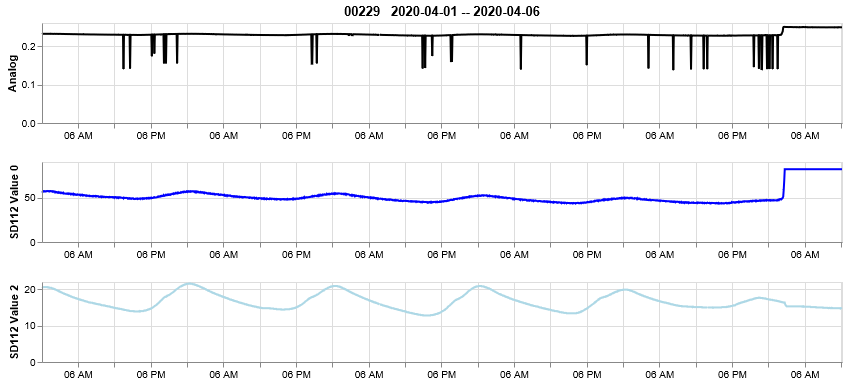

In [13]:
# Make temperature charts for specific timeframe
charts = []
device_names=['A000229']
for i in range(len(device_names)):
    de = arable_query('all', 'csv', device_ids[i], "aux_raw", "time", (m_end[i])[-1], (m_start[i])[-1])
    de['time'] = pd.to_datetime(de['time'],infer_datetime_format=True)
    base = alt.Chart(de, 
                     title = str((device_names[i])[2:]) + ' \n ' + str(((m_start[i])[-1])[:10]) + ' -- ' + str((m_end[i])[-1])[:10]
    ).mark_line(color = 'black'
    ).properties(width  = 800, 
                 height = 100
    ).encode(x = alt.X('time:T', axis=alt.Axis(title='')),
             y = alt.Y('analog:Q', axis=alt.Axis(title='Analog')))
    z = alt.Chart(de, 
    ).mark_line(color = 'blue'
    ).properties(width  = 800,
                 height = 80
    ).encode(x = alt.X('time:T', axis=alt.Axis(title='')),
             y = alt.Y('sdi12_value_0:Q', axis=alt.Axis(title='SD112 Value 0')))
    q = alt.Chart(de, 
    ).mark_line(color = 'lightblue'
    ).properties(width  = 800,
                 height = 80
    ).encode(x = alt.X('time:T', axis=alt.Axis(title='')),
             y = alt.Y('sdi12_value_2:Q', axis=alt.Axis(title='SD112 Value 2')))
    graph = alt.vconcat(base, z, q)
    charts.append(graph)
alt.vconcat(*charts)

In [14]:
df = StringIO(df)
df = pd.read_csv(df, sep=',', error_bad_lines=False)

fig, ax = plt.subplots(figsize=(3, 3))
ax = plt.gca()

df.plot(kind='line',x='time',y='Tabove',ax=ax)
df.plot(kind='line',x='time',y='Tbelow', color='red', ax=ax)
df.plot(kind='line',x='time',y='Tair', color='green', ax=ax)
df.plot(kind='line',x='time',y='Tdew', color='blue', ax=ax)
plt.xlabel('')
plt.ylabel('Deg. C')
plt.title(str((device_names[0])[1:]) + ' \n ' + str(((sta_m[0])[0])[:10]) + ' -- ' + str((end_m[0])[0])[:10])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

NameError: name 'df' is not defined